## 8. 챗봇 엔진 만들기

### 8.1. 챗봇 엔진

- 챗봇에서 핵심 기능을 하는 모듈이며, 화자의 질문을 이해하고 알맞은 답변을 출력하는 역할
- 자연어 처리 모듈인 셈

- 최근에는 음성 챗봇을 활용해 전화상담까지 기능한 기술수준까지 도달해 있음

- 현재 국내외 업체들이 개발한 챗봇 엔진을 활용하는 봇 빌더가 많이 출시됨. 봇빌더를 이용하면 기술적 이해 없이도 성능 좋은 챗봇을 쉽게 만들 수 있음 (예: 카카오톡, 네이버톡톡)

- 학습방향
    - 챗봇에 관심 있는 초심자들에게 간단하게 이런 상용 챗봇 엔진들이 어떤 원리로 구현되는지,각 전문분야에 맞는 챗봇을 어떻게 구축할 수 있는지에 대한 아이디어와 힌트를 주는 것
    
### 8.2. 챗봇 엔진 구조

- 토이 수준의 챗봇 엔진의 5가지 기능

    ① 질문의도 분류: 화자의 질문 의도 파악, 의도 분류 모델 이용해 의도클래스 예측
    
    ② 개체명 인식: 화자의 질문에서 단어 토큰별 개체명 인식. 단어 토큰에 맞는 개체명을 예측하는 문제
    
    ③ 핵심 키워드 추출: 화자의 질문 의미에서 핵심이 될만한 단어 토큰을 추출. 형태소 분석기를 이용해 핵심 키워드가 되는 명사나 동사 추출
    
    ④ 답변 검색: 해당 질문의 의도, 개체명, 핵심 키워드 등을 기반으로 답변을 학습DB에서 검색
    
    ⑤ 소켓 서버: 챗봇 클라이언트에서 요청하는 질문을 요청하기 위한 소켓 서버 프로그램 역할. 챗봇 엔진 서버 프로그램

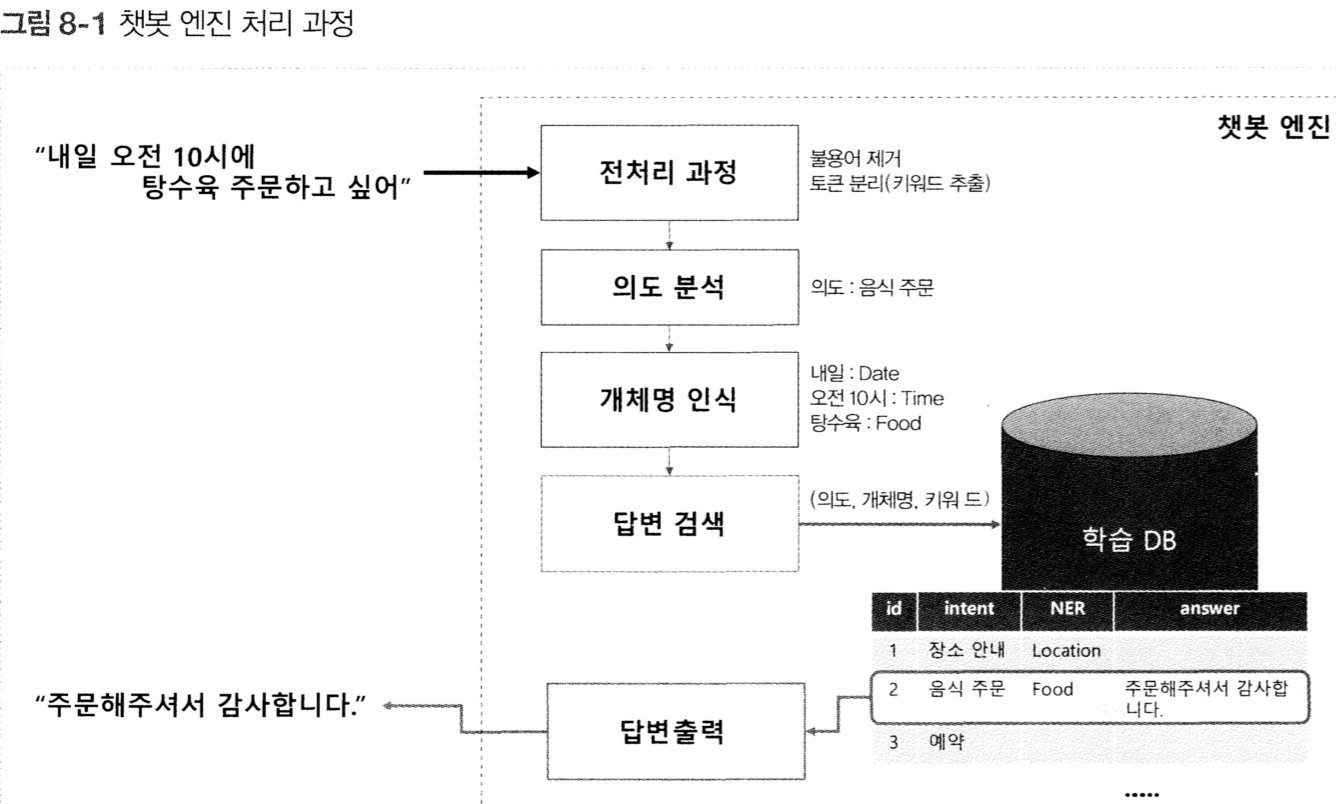

In [29]:
from IPython.display import Image
Image('Data/230630/5.png', width = 600)

#### [챗봇 엔진 처리 과정] 

① 질의 문장 입력

② 전처리: 토크나이징
- 1 : 형태소 분석기를 이용해 단어 토큰(키워드)을 추출한 뒤 
- 2 : 명사나 동사 등 필요한 품사만 남기고 불용어는 제거
    
③ 의도 분석과 개체명 인식: 딥러닝 모델 사용
- 해당 도메인 지식에 맞는 딥러닝 모델 학습 데이터셋을 많이 보유하고 있다면 성능이 우수한 챗봇 엔진 개발에 도움이 됨

④ 결괏값을 이용해 적절한 답변을 학습 DB 에서 검색

⑤ 화자에게 답변을 출력

#### 룰 베이스와 딥러닝 모델을 같이 사용하는 방법으로 챗봇 엔진 만들어 봄

자주 반복되고 빈도가 높은 문제에 대해서는 작은 학습 데이터셋만 가지고도 딥러닝 모델보다 품질이 우수한 결과를 보일 수 있음. 무조건 딥러닝 모델이 좋은 것이 아니라 상황에 따라 룰 베이스모델이나 확률 모델이 적합한 경우도 있음

### 8.3. 전처리 과정

- 전처리 모듈의 경우 챗봇 엔진 내에서 자주 사용하기 때문에 클래스로 정의함
    - 챗봇 엔진에 새로운 전처리 과정이 필요하면 해당 객체에 새로운 기능으로 추가할 것임

### [예제8-1] 챗봇 전처리 클래스

/utils 내에 Preprocess.py 소스파일 생성

#### komora.pos: 형태소와 품사 태그 추출

In [35]:
from konlpy.tag import Komoran
class Preprocess:
    def __init__(self, userdic=None):   # 생성자
        # 형태소 분석기 초기화
        self.komoran = Komoran(userdic = userdic)    # 사용자 정의 사전 파일의 경로 입력가능

        # 제외할 품사
        # 참조: https://docs.komoran.kr/firststep/postypes.html
        # 관계언 제거, 기호 제거
        # 어미 제거
        # 접미사 제거
        self.exclusion_tags = [
            'JKS','JKC','JKG','JKO','JKB','JKV','JKQ',
            'JX','JC',
            'SF','SP','SS','SE','SO',
            'EP','EF','EC','ETN','ETM',
            'XSN','XSV','XSA'
        ]

    # 형태소 분석기 POS 태거
    def pos(self, sentence):
        return self.komoran.pos(sentence)      # pos: 형태소와 품사 태그 추출
        # 외부에서는 코모란 형태소 분석기 객체를 직접적으로 호출하지 않도록 정의한 래퍼 함수
    
    # 불용어 제거 후 필요한 품사 정보만 가져오기
    def get_keywords(self, pos, without_tag = False):
        f = lambda x: x in self.exclusion_tags
        word_list = []
        for p in pos:
            if f(p[1]) is False:
                word_list.append(p if without_tag is False else p[0])
        return word_list

### [예제8-2] 전처리클래스 테스트

/test 디렉터리에 preprocess_test. py 파일 생성

In [36]:
# from utils.Preprocess import Preprocess

sent = '내일 오전 10시에 탕수육 주문하고 싶어'

# 전처리 객체 생성
p = Preprocess(userdic = 'Data/230703/user_dic.tsv')

# 형태소 분석기 실행
pos = p.pos(sent)
print(pos)

# 품사 태그와 같이 키워드 출력
ret = p.get_keywords(pos, without_tag = False)
print(ret)

# 품사 태그 없이 키워드 출력
ret = p.get_keywords(pos, without_tag = True)
print(ret)

[('내일', 'NNG'), ('오전', 'NNP'), ('10시', 'NNG'), ('에', 'JKB'), ('탕수육', 'NNG'), ('주문', 'NNG'), ('하', 'XSV'), ('고', 'EC'), ('싶', 'VX'), ('어', 'EC')]
[('내일', 'NNG'), ('오전', 'NNP'), ('10시', 'NNG'), ('탕수육', 'NNG'), ('주문', 'NNG'), ('싶', 'VX')]
['내일', '오전', '10시', '탕수육', '주문', '싶']


### 8.4. 단어사전 구축 및 시퀀스 생성

테스트 과정에서 사용한 단어가 사전에 존재하지 않을 수 있음. 이 경우 챗봇 엔진에서 OOV처리를 하지만 품질 향상을 위해 단어사전을 업데이트하는 것이 좋음. corpus.txt 파일에 \t 사용해 컬럼에 맞게 추가하는 것으로 말뭉치 업데이트

/train tools/dict/ 디렉터리에 corpus.txt 말뭉치 데이터 위치

### [예제8-3] 단어사전 생성

같은위치에 단어 사전을 생성하는 코드 작성 create_dict.py

In [69]:
# from utils.Preprocess import Preprocess
from tensorflow.keras import preprocessing
import pickle

# 말뭉치 데이터 읽어오기
def read_corpus_data(filename):
    with open(filename, 'r', encoding = 'utf8') as f:   # encoding 추가
        data = [line.split('\t') for line in f.read().splitlines()]
        data = data[1:]  # 헤더 제거
    return data

# 말뭉치 데이터 가져오기
corpus_data = read_corpus_data('Data/230703/corpus2.txt')
#### 네이버 영화 리뷰 말뭉치 데이터 기반으로 만든 데이터

# 말뭉치 데이터에서 키워드만 추출해서 사전 리스트 생성
p = Preprocess(word2index_dic='Data/230703/chatbot_dict.bin',
               userdic = 'Data/230703/user_dic.tsv')    ######## 인자 추가!!!
dict = []
for c in corpus_data:
    pos = p.pos(c[1])
    for k in pos:
        dict.append(k[0])

# 사전에 사용될 word2index 생성
# 사전에 첫 번째 인덱스에는 OOV 사용
tokenizer = preprocessing.text.Tokenizer(oov_token = 'OOV')
tokenizer.fit_on_texts(dict)
word_index = tokenizer.word_index

# 사전 파일 생성
f = open('Data/230703/chatbot_dict2.bin', 'wb')
try:
    pickle.dump(word_index, f)
except Exception as e:
    print(e)     
    
finally:
    f.close()

In [70]:
p.pos(corpus_data[0][1])[0][0]

'헬로'

In [71]:
dict[:10]

['헬로', '안부', '인사', '드리', 'ㅂ니다', '.', '먼저', '인사', '하', '려고']

####  tensorflow.keras.preprocessing.text 모듈의 Tokenizer 클래스

Tokenizer: 문장으로부터 단어를 토큰화하고 숫자에 대응시키는 딕셔너리를 사용
- oov_token 인자를 사용하면 미리 인덱싱하지 않은 단어들은 ‘<OOV>’로 인덱싱됨
    
fit_on_texts(): 문자 데이터를 입력받아서 리스트의 형태로 변환

word_index : 단어와 숫자의 키-값 쌍을 포함하는 딕셔너리를 반환

texts_to_sequences(): 텍스트 안의 단어들을 숫자의 시퀀스의 형태로 변환

In [40]:
word_index

{'OOV': 1,
 '하': 2,
 '주문': 3,
 '시': 4,
 '분': 5,
 '가능': 6,
 '예약': 7,
 '주': 8,
 '어요': 9,
 '고': 10,
 '싶': 11,
 '어': 12,
 '모레': 13,
 '내일': 14,
 '변경': 15,
 'ㄹ': 16,
 '취소': 17,
 '요': 18,
 '이': 19,
 '아': 20,
 '되': 21,
 '게': 22,
 'ㄴ': 23,
 '나요': 24,
 '있': 25,
 '수': 26,
 '다음': 27,
 '어떻': 28,
 'ㄴ가요': 29,
 '에': 30,
 '금주': 31,
 '로': 32,
 '는': 33,
 '을': 34,
 '나': 35,
 'ㅂ니다': 36,
 '가요': 37,
 '시간': 38,
 '으로': 39,
 '오늘': 40,
 '은데': 41,
 '다': 42,
 '가': 43,
 '덮밥': 44,
 '금일': 45,
 '밥': 46,
 '음식': 47,
 'ㄹ까요': 48,
 '문': 49,
 '아야': 50,
 '습니다': 51,
 '바로': 52,
 '4': 53,
 '었': 54,
 '은': 55,
 '1': 56,
 'ㄹ게요': 57,
 '겠': 58,
 '도': 59,
 '삼': 60,
 '국수': 61,
 '진행': 62,
 '콜': 63,
 '빵': 64,
 '거': 65,
 '드리': 66,
 '메뉴': 67,
 '의': 68,
 'ㄹ께': 69,
 '15': 70,
 '20': 71,
 '17': 72,
 '지': 73,
 '받': 74,
 '18': 75,
 '라면': 76,
 '았': 77,
 '11': 78,
 '지금': 79,
 '달걀': 80,
 '는데': 81,
 '5': 82,
 '면': 83,
 '날짜': 84,
 '톡': 85,
 '12': 86,
 '담': 87,
 '를': 88,
 '8': 89,
 '16': 90,
 '짜': 91,
 '19': 92,
 '14': 93,
 '보': 94,
 '당일': 95,
 '아요'

### [예제 8-4] 단어사전 테스트코드

/test 디렉터리에 chatbot_dict_test.py 

In [72]:
# from utils.Preprocess import Preprocess
import pickle

# 단어 사전 불러오기
f = open('Data/230703/chatbot_dict2.bin', 'rb')
word_index = pickle.load(f)
f.close()

sent = '내일 오전 10시에 새우볶음밥 주문하고 싶어 ㅋㅋ'

# 전처리 객체 생성
p = Preprocess(userdic = 'Data/230703/user_dic.tsv')

# 형태소 분석기 실행
pos = p.pos(sent)

# 품사 태그 없이 키워드 출력
keywords = p.get_keywords(pos, without_tag = True)
for word in keywords:
    try:
        print(word, word_index[word])
    except KeyError:
        # 해당 단어가 사전에 없는 경우 OOV처리
        print(word, word_index['OOV'])


내일 12
오전 214
10시 81
새우볶음밥 526
주문 3
싶 9
ㅋㅋ 10846


### [예제8-5] 메서드 추가

/utils 내에 Preprocess.py

In [73]:
from konlpy.tag import Komoran
import pickle

class Preprocess:
    def __init__(self, word2index_dic='',userdic=None):   # 생성자
        # 형태소 분석기 초기화
        self.komoran = Komoran(userdic = userdic)

        # 제외할 품사 
        self.exclusion_tags = [
            'JKS','JKC','JKG','JKO','JKB','JKV','JKQ',
            'JX','JC',
            'SF','SP','SS','SE','SO',
            'EP','EF','EC','ETN','ETM',
            'XSN','XSV','XSA'
        ]

        # 단어 인덱스 사전 불러오기       <================================ 추가
        if(word2index_dic != ''):
            f = open(word2index_dic, 'rb')
            self.word_index = pickle.load(f)
            f.close()
        else:
            self.word_index = None

    # 형태소 분석기 POS 태거
    def pos(self, sentence):
        return self.komoran.pos(sentence)
    
    # 불용어 제거 후 필요한 품사 정보만 가져오기
    def get_keywords(self, pos, without_tag = False):
        f = lambda x: x in self.exclusion_tags
        word_list = []
        for p in pos:
            if f(p[1]) is False:
                word_list.append(p if without_tag is False else p[0])
        return word_list
    
    # 키워드를 단어 인덱스 시퀀스로 변환 <================================ 추가
    def get_wordidx_sequence(self, keywords):
        if self.word_index is None:
            return []
        w2i = []
        for word in keywords:
            try:
                w2i.append(self.word_index[word])
            except KeyError:
                # 해당 단어가 사전에 없는 경우 OOV처리
                w2i.append(self.word_index['OOV'])
        return w2i

### 8-5. 의도분류모델

챗봇 엔진에 화자의 질의가 입력되었을 때, 전처리 과정 거친 후 해당 문장의 의도를 분류함
- 의도 클래스별로 분류하기 위해 CNN모델 사용
- 0 인사, 1 욕설, 2 주문, 3 예약, 4 기타

### [예제8-6] 글로벌 파라미터 정보

config/  GlobalParams.py

In [74]:
# 단어 시퀀스 벡터 크기

MAX_SEQ_LEN = 15

def GlobalParams():
    global MAX_SEQ_LEN

### [예제8-7] 챗봇 엔진 의도 분류 모델

models/itent 디렉터리 total_train_data.csv 파일 

train_model.py

In [75]:
import pandas as pd
import tensorflow as tf
from tensorflow.keras import preprocessing
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Embedding, Dense, Dropout, Conv1D, GlobalMaxPool1D, concatenate

# 데이터 읽어오기
train_file = 'Data/230703/total_train_data.csv'
data = pd.read_csv(train_file, delimiter = ',')
queries = data['query'].tolist()
intents = data['intent'].tolist()
# from utils.Preprocess import Preprocess
p = Preprocess(word2index_dic = 'Data/230703/chatbot_dict2.bin', userdic= 'Data/230703/user_dic.tsv')

In [76]:
queries[:10]

['헬로우',
 '헬로',
 '안부 인사드립니다.',
 '먼저 인사하려고 했는데 짝남이 먼저 인사해줬어. 더 떨렸겠어요.',
 '먼저 인사할까 했는데 짝녀가 먼저 인사해줬어. 기분 좋았겠네요.',
 '각자 집에 인사드리러 가 제가 더 떨리네요.',
 '이별의 마무리 가벼운 안부 인사일 거예요.',
 '용기내서 새해인사 했네 이제 연락하지 마세요.',
 '오늘 마지막 인사를 하러가네 미련없길 바랄게요.',
 '오늘 마지막 인사하러 갑니다. 미련없이 정리했긴 바랍니다.']

In [77]:
intents[:10]

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0]

In [78]:
# 단어 시퀀스 생성
sequences = []
for sentence in queries:
    pos = p.pos(sentence)
    keywords = p.get_keywords(pos, without_tag =True)
    seq = p.get_wordidx_sequence(keywords)
    sequences.append(seq)

# 단어 시퀀스 벡터 크기
# from config.GlobalParams import MAX_SEQ_LEN
padded_seqs = preprocessing.sequence.pad_sequences(sequences, maxlen = MAX_SEQ_LEN, padding = 'post')

In [79]:
sequences[:10]

[[1],
 [6825],
 [3071, 1109, 56],
 [716, 1109, 2, 587, 945, 716, 1109, 7, 119, 1198],
 [716, 1109, 2, 587, 696, 716, 1109, 7, 766, 133],
 [2216, 543, 1109, 56, 41, 569, 119, 1198],
 [540, 1434, 1536, 3071, 1109, 20, 57],
 [950, 157, 800, 6826, 2, 592, 548, 153],
 [39, 1, 2, 41, 891, 145, 593],
 [39, 1, 41, 891, 864, 665, 593]]

In [80]:
padded_seqs

array([[    1,     0,     0, ...,     0,     0,     0],
       [ 6825,     0,     0, ...,     0,     0,     0],
       [ 3071,  1109,    56, ...,     0,     0,     0],
       ...,
       [11354,     0,     0, ...,     0,     0,     0],
       [11355,     0,     0, ...,     0,     0,     0],
       [11356,     0,     0, ...,     0,     0,     0]])

In [81]:
# 학습용, 검증용, 테스트용 데이터셋 생성 7:2:1
ds = tf.data.Dataset.from_tensor_slices((padded_seqs, intents))
ds = ds.shuffle(len(queries))

train_size = int(len(padded_seqs) * 0.7)
val_size = int(len(padded_seqs) * 0.2)
test_size = int(len(padded_seqs) * 0.1)

train_ds = ds.take(train_size).batch(20)
val_ds = ds.skip(train_size).take(val_size).batch(20)
test_ds = ds.skip(train_size + val_size).take(test_size).batch(20)

In [82]:
# 하이퍼파라미터 설정
dropout_prob = 0.5
EMB_SIZE = 128
EPOCH = 5
VOCAB_SIZE = len(p.word_index) + 1   # 전체단어 수

In [83]:
# CNN모델 정의
input_layer = Input(shape = (MAX_SEQ_LEN,))

# 임베딩처리
embedding_layer = Embedding(VOCAB_SIZE, EMB_SIZE, input_length = MAX_SEQ_LEN)(input_layer)  

#평탄화 
dropout_emb = Dropout(rate = dropout_prob)(embedding_layer)   

conv1 = Conv1D(
    filters = 128,
    kernel_size = 3, 
    padding = 'valid',
    activation = tf.nn.relu)(dropout_emb)
pool1 = GlobalMaxPool1D()(conv1)

conv2 = Conv1D(
    filters = 128,
    kernel_size = 4, 
    padding = 'valid',
    activation = tf.nn.relu)(dropout_emb)
pool2 = GlobalMaxPool1D()(conv2)

conv3 = Conv1D(
    filters = 128,
    kernel_size = 5, 
    padding = 'valid',
    activation = tf.nn.relu)(dropout_emb)
pool3 = GlobalMaxPool1D()(conv3)

# 3,4,5-gram 이후 합치기
concat = concatenate([pool1, pool2, pool3])

### 5가지 클래스를 분류해야 하므로, 출력노드가 5개인 Dense 계층을 생성함
### (최종단계에서는 활성화함수 사용하지 않음)
### 해당 계층에서나온 값 logits들을 점수(score)라고 부름
### 출력노드 5개의 점수가 출력된 후, 가장 큰 점수를 가진 노드 위치가 CNN모델이 예측한 의도 클래스가 됨
hidden = Dense(128, activation = tf.nn.relu)(concat)
dropout_hidden = Dropout(rate = dropout_prob)(hidden)
logits = Dense(5, name = 'logits')(dropout_hidden)

# logits에서 나온 점수를 소프트맥스를 통해 감정 클래스별 확률을 계산함
predictions = Dense(5, activation = tf.nn.softmax)(logits)

# 모델생성
model = Model(inputs = input_layer, outputs = predictions)
model.compile(optimizer = 'adam', loss = 'sparse_categorical_crossentropy', metrics = ['accuracy'])

# 모델 학습
model.fit(train_ds, validation_data = val_ds, epochs = EPOCH, verbose= 1)

# 모델 평가 
loss, accuracy = model.evaluate(test_ds, verbose = 1)
print('Accuracy: %f' %(accuracy * 100))
print('loss: %f' %(loss))

# 모델 저장
model.save('Data/230703/intent_model2.h5')

Epoch 1/5
3698/3698 [==============================] - 154s 41ms/step - loss: 0.0492 - accuracy: 0.9851 - val_loss: 0.0132 - val_accuracy: 0.9932
Epoch 2/5
3698/3698 [==============================] - 151s 41ms/step - loss: 0.0157 - accuracy: 0.9944 - val_loss: 0.0098 - val_accuracy: 0.9955
Epoch 3/5
3698/3698 [==============================] - 148s 40ms/step - loss: 0.0123 - accuracy: 0.9956 - val_loss: 0.0081 - val_accuracy: 0.9959
Epoch 4/5
3698/3698 [==============================] - 141s 38ms/step - loss: 0.0091 - accuracy: 0.9965 - val_loss: 0.0093 - val_accuracy: 0.9963
Epoch 5/5
529/529 [==============================] - 1s 1ms/step - loss: 0.0062 - accuracy: 0.9963
Accuracy: 99.630857
loss: 0.006163


### [예제8-8] 의도분류모델 모듈

models/intent 디렉터리  IntentModel.py

In [86]:
import tensorflow as tf
from tensorflow.keras.models import Model, load_model
from tensorflow.keras import preprocessing


# 의도분류모델 모듈
class IntentModel:
    def __init__(self, model_name, preprocess):
        # 의도클래스별 레이블
        self.labels = {0: '인사', 1: '욕설', 2: '주문', 3: '예약', 4:'기타'}

        # 의도 분류모델 불러오기
        self.model = load_model(model_name)

        # 챗봇 preprocess 객체
        self.p = preprocess

    # 의도클래스 예측
    def predict_class(self, query):
        # 형태소분석
        pos = self.p.pos(query)

        # 문장 내 키워드 추출(불용어 제거)
        keywords = self.p.get_keywords(pos, without_tag = True)
        sequences = [self.p.get_wordidx_sequence(keywords)]

        # 단어 시퀀스벡터 크기
#         from config.GlobalParams import MAX_SEQ_LEN

        # 패딩처리
        padded_seqs = preprocessing.sequence.pad_sequences(sequences, maxlen = MAX_SEQ_LEN, padding = 'post')
        
        predict = self.model.predict(padded_seqs)
        predict_class = tf.math.argmax(predict, axis = 1)
        return predict_class.numpy()[0]

### [예제8-9] 의도분류모델 테스트

test/ model_intent_test.py

In [87]:
# from utils.Preprocess import Preprocess
# from models.intent.IntentModel import IntentModel

p = Preprocess(word2index_dic = 'Data/230703/chatbot_dict2.bin', userdic = 'Data/230703/user_dic.tsv')

intent = IntentModel(model_name= 'Data/230703/intent_model2.h5', preprocess = p)

query = '오늘 탕수육 주문 가능한가요?'
predict = intent.predict_class(query)
predict_label = intent.labels[predict]

print(query)
print("의도 예측 클래스: ", predict)
print("의도 예측 레이브: ", predict_label)

1/1 [==============================] - 0s 105ms/step
오늘 탕수육 주문 가능한가요?
의도 예측 클래스:  2
의도 예측 레이브:  주문


### 8-6 개체명 인식 모델 학습  NER

B_FOOD    음식

B_DT, B_TI   날짜, 시간

B_PS      사람

B_OG      조직, 회사

B_LC      지역
